In [52]:
import sys
import os
print(sys.executable)

/Users/Ram/projects/r3 /agent_env/bin/python


In [53]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))  # goes up from notebook/ to project root

In [54]:
from src.utils.model_loader import ModelLoader

In [55]:
model_loader = ModelLoader()

{"timestamp": "2026-02-21T10:12:20.592065Z", "level": "warning", "event": "OPENAI_API_KEY is missing from environment"}
{"timestamp": "2026-02-21T10:12:20.593178Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2026-02-21T10:12:20.593541Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2026-02-21T10:12:20.593802Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2026-02-21T10:12:20.594071Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2026-02-21T10:12:20.594287Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2026-02-21T10:12:20.596417Z", "level": "info", "event": "YAML config loaded"}


In [56]:
llm = model_loader.load_llm()

{"provider": "groq", "model": "openai/gpt-oss-20b", "timestamp": "2026-02-21T10:12:20.599988Z", "level": "info", "event": "Loading LLM"}


In [57]:
llm.invoke('hi')

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "hi". We need to respond. The instruction: "You are ChatGPT, a large language model trained by OpenAI." There\'s no special instruction. Just respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 72, 'total_tokens': 129, 'completion_time': 0.064461926, 'completion_tokens_details': {'reasoning_tokens': 39}, 'prompt_time': 0.003380262, 'prompt_tokens_details': None, 'queue_time': 0.016141301, 'total_time': 0.067842188}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_d3e146e1a5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--019c7faf-9a18-7e52-a24e-c74c5ceaf469-0', usage_metadata={'input_tokens': 72, 'output_tokens': 57, 'total_tokens': 129})

In [58]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field



In [59]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [60]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [61]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [62]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [63]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [64]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [65]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [66]:
create_analyst(
    {'topic': 'Education',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Maya Patel', role='Technology Integration Analyst', affiliation='Global Institute for Digital Learning', description='Dr. Patel focuses on the integration of AI and adaptive learning platforms in K-12 and higher education, assessing pedagogical outcomes, data privacy, and scalability.'),
  Analyst(name='Prof. Samuel Okoye', role='Equity and Inclusion Analyst', affiliation='Center for Inclusive Education Studies', description='Prof. Okoye examines systemic barriers to educational access, evaluating policy interventions, resource allocation, and culturally responsive curricula to promote equity across socioeconomic and demographic groups.')]}

In [67]:
def human_feedback(state):
    pass

In [68]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [69]:
from IPython.display import Image, display


Workflow

In [70]:
builder = StateGraph(GenerateAnalystsState)



In [71]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [72]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                                should_continue,
                                ["create_analyst",
                                END])

In [73]:
memory = MemorySaver()

In [74]:
graph = builder.compile(interrupt_before = ["human_feedback"], checkpointer = memory)

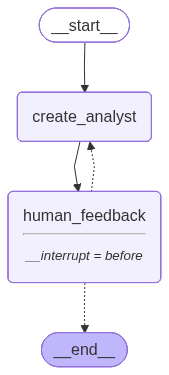

In [75]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [76]:
topic = "the benefits of adopting Langgraph as an agent framework"


In [77]:
max_analysts = 4


In [78]:
thread =  {"configurable":{"thread_id":1}}


In [95]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Rivera
Affiliation: TechNova Inc.
Role: Startup CTO
Description: Focuses on rapid prototyping, cost-efficiency, and scaling from MVP to production using Langgraph. Evaluates how Langgraph accelerates feature delivery and reduces engineering overhead for early-stage startups.
--------------------------------------------------
Name: Maya Chen
Affiliation: GlobalBank Systems
Role: Enterprise Solutions Architect
Description: Examines Langgraph's integration with legacy enterprise stacks, compliance, security, and governance. Assesses how Langgraph supports complex workflows and data privacy in large organizations.
--------------------------------------------------
Name: Dr. Ravi Patel
Affiliation: CloudOps Labs
Role: Reliability Engineer
Description: Analyzes performance, fault tolerance, and observability of Langgraph in production. Looks at latency, throughput, and resilience for mission-critical applications.
--------------------------------------------------
Name: Lena Kim
A

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Alex Rivera
Affiliation: TechNova Inc.
Role: Startup CTO
Description: Focuses on rapid prototyping, cost-efficiency, and scaling from MVP to production using Langgraph. Evaluates how Langgraph accelerates feature delivery and reduces engineering overhead for early-stage startups.
--------------------------------------------------
Name: Maya Chen
Affiliation: GlobalBank Systems
Role: Enterprise Solutions Architect
Description: Examines Langgraph's integration with legacy enterprise stacks, compliance, security, and governance. Assesses how Langgraph supports complex workflows and data privacy in large organizations.
--------------------------------------------------
Name: Dr. Ravi Patel
Affiliation: CloudOps Labs
Role: Reliability Engineer
Description: Analyzes performance, fault tolerance, and observability of Langgraph in production. Looks at latency, throughput, and resilience for mission-critical applications.
--------------------------------------------------
Name: Lena Kim
A

In [96]:
state = graph.get_state(thread)

In [97]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Alex Rivera', role='Startup CTO', affiliation='TechNova Inc.', description='Focuses on rapid prototyping, cost-efficiency, and scaling from MVP to production using Langgraph. Evaluates how Langgraph accelerates feature delivery and reduces engineering overhead for early-stage startups.'), Analyst(name='Maya Chen', role='Enterprise Solutions Architect', affiliation='GlobalBank Systems', description="Examines Langgraph's integration with legacy enterprise stacks, compliance, security, and governance. Assesses how Langgraph supports complex workflows and data privacy in large organizations."), Analyst(name='Dr. Ravi Patel', role='Reliability Engineer', affiliation='CloudOps Labs', description='Analyzes performance, fault tolerance, and o

In [98]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Alex Rivera', role='Startup CTO', affiliation='TechNova Inc.', description='Focuses on rapid prototyping, cost-efficiency, and scaling from MVP to production using Langgraph. Evaluates how Langgraph accelerates feature delivery and reduces engineering overhead for early-stage startups.'),
  Analyst(name='Maya Chen', role='Enterprise Solutions Architect', affiliation='GlobalBank Systems', description="Examines Langgraph's integration with legacy enterprise stacks, compliance, security, and governance. Assesses how Langgraph supports complex workflows and data privacy in large organizations."),
  Analyst(name='Dr. Ravi Patel', role='Reliability Engineer', affiliation='CloudOps Labs', description='Analyzes performance, fault tolerance, and observability o

In [100]:
memory.storage.items()


dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f10f0dc-f85c-60d0-bfff-f5a2536266ae': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-02-21T10:12:21.583684+00:00\xa2id\xd9$1f10f0dc-f85c-60d0-bfff-f5a2536266ae\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.2562962650114826\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f10f0dc-f85e-6574-8000-ae635e4184fd': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-02-21T10:12:21.584610+00:00\xa2id\xd9$1f10f0dc-f85e-6574-8000-ae635e4184fd\xb0channel_versions\x84\xa9__start__\xd9200000000000000000000000000000002.0.207137703518271\xa5topic\xd9200000000000000000000000000000002.0.207137703518271\xacmax_analysts\xd9200000000000000000000000000000002.0.207137703518271\xb8branch:to:create_analyst\xd9200000000000000000000000000000002.0.207137703518271\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\xd9300

In [101]:
state.next

('human_feedback',)

In [102]:
state.config


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10f0ec-d526-675e-8009-6a47f88fce5a'}}

In [104]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10f0ef-ded5-6612-800b-bb0064de33ea'}}

In [106]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Rivera
Affiliation: TechNova Inc.
Role: Startup CTO
Description: Focuses on rapid prototyping, cost-efficiency, and scaling from MVP to production using Langgraph. Evaluates how Langgraph accelerates feature delivery and reduces engineering overhead for early-stage startups.
--------------------------------------------------
Name: Maya Chen
Affiliation: GlobalBank Systems
Role: Enterprise Solutions Architect
Description: Examines Langgraph's integration with legacy enterprise stacks, compliance, security, and governance. Assesses how Langgraph supports complex workflows and data privacy in large organizations.
--------------------------------------------------
Name: Dr. Ravi Patel
Affiliation: CloudOps Labs
Role: Reliability Engineer
Description: Analyzes performance, fault tolerance, and observability of Langgraph in production. Looks at latency, throughput, and resilience for mission-critical applications.
--------------------------------------------------
Name: Lena Kim
A

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Alex Rivera
Affiliation: Tech Startup Inc.
Role: Product Strategy Analyst
Description: Alex focuses on how Langgraph can accelerate MVP development, reduce time-to-market, and enable rapid iteration for early-stage startups. He is concerned with cost-efficiency, ease of onboarding, and the ability to pivot quickly based on user feedback.
--------------------------------------------------
Name: Maya Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Architecture Analyst
Description: Maya evaluates Langgraph’s fit within complex enterprise ecosystems, emphasizing integration with legacy systems, compliance with data governance, and scalability across multi-cloud environments. She is motivated by ensuring robust security, auditability, and seamless deployment at scale.
--------------------------------------------------
Name: Ravi Patel
Affiliation: High-Performance Computing Labs
Role: Systems Performance Analyst
Description: Ravi examines Langgraph’s runtime performance

In [107]:
state = graph.get_state(thread)

In [108]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Alex Rivera', role='Product Strategy Analyst', affiliation='Tech Startup Inc.', description='Alex focuses on how Langgraph can accelerate MVP development, reduce time-to-market, and enable rapid iteration for early-stage startups. He is concerned with cost-efficiency, ease of onboarding, and the ability to pivot quickly based on user feedback.'), Analyst(name='Maya Chen', role='Enterprise Architecture Analyst', affiliation='Global Enterprise Solutions', description='Maya evaluates Langgraph’s fit within complex enterprise ecosystems, emphasizing integration with legacy systems, compliance with data governance, and scalability across multi-cloud environments. She is motivated by ensuring robust security, auditability, and seamless depl

In [109]:
state.next

('human_feedback',)

In [110]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Alex Rivera', role='Product Strategy Analyst', affiliation='Tech Startup Inc.', description='Alex focuses on how Langgraph can accelerate MVP development, reduce time-to-market, and enable rapid iteration for early-stage startups. He is concerned with cost-efficiency, ease of onboarding, and the ability to pivot quickly based on user feedback.'),
  Analyst(name='Maya Chen', role='Enterprise Architecture Analyst', affiliation='Global Enterprise Solutions', description='Maya evaluates Langgraph’s fit within complex enterprise ecosystems, emphasizing integration with legacy systems, compliance with data governance, and scalability across multi-cloud environments. She is motivated by ensuring robust security, auditability, and seamless deployment at scale.